#Procesamiendo de Imagenes
##Trabajo Practico nº1 

In [ ]:
from ipywidgets import widgets as wg
from IPython.display  import clear_output, display
from tkinter import Tk, filedialog
import panel as pn
import panel.interact as interact
pn.extension()

import cv2
import numpy as np
import matplotlib.pyplot as plt


from PIL import Image
import requests
from io import BytesIO

In [ ]:
def resume_path(path, length = 50):
    index = len(path) - length    
    return f'...{path[index:]}'

def convert_RGB_to_YIQ(rgb_img):
    rgb_to_yiq = np.array([[0.299,      0.587,   0.114],
                         [0.595716, -0.274453, -0.321263],
                         [0.211456, -0.522591, 0.311135]])
    rgb_dtype_float = rgb_img.astype(float)
    rgb_normalize = rgb_dtype_float / 255
    return np.dot(rgb_normalize, rgb_to_yiq.T.copy())
        
def convert_YIQ_to_RGB(yiq_img_normalize):
    yiq_to_rgb = np.array([[1,      0.9663,   0.6210],
                         [1, -0.2721, -0.6474],
                         [1, -1.1070, 1.7046]])
    rgb_normalize = np.dot(yiq_img_normalize, yiq_to_rgb.T.copy())
    rgb_dtype_float = rgb_normalize * 255
    return (rgb_dtype_float.astype(int))

def customize_YIQ_image(yiq_narray, alfa = 1, beta =1):
    yiq_customize = yiq_narray.copy()
    y_component = yiq_customize[:,:,0] * alfa
    i_component = yiq_customize[:,:,1] * beta
    q_component = yiq_customize[:,:,2] * beta
    
    yiq_customize[:,:,0][yiq_customize[:,:,0] > 1] = 1.
    yiq_customize[:,:,1][yiq_customize[:,:,1] < -0.5957] = -0.5957
    yiq_customize[:,:,1][yiq_customize[:,:,1] > 0.5957] = 0.5957
    yiq_customize[:,:,2][yiq_customize[:,:,2] < -0.5226] = -0.5226
    yiq_customize[:,:,2][yiq_customize[:,:,2] > 0.5226] = 0.5226

    yiq_customize[:,:,0] = y_component
    yiq_customize[:,:,1] = i_component
    yiq_customize[:,:,2] = q_component
    return yiq_customize

def get_custom_rgb_from_yiq(yiq_img, alfa =1, beta=1):
    return convert_YIQ_to_RGB(customize_YIQ_image(yiq_img, alfa, beta))

def custom_rgb_img(rgb_img, alfa=1, beta=1):
    yiq_img = convert_RGB_to_YIQ(rgb_img)
    return get_custom_rgb_from_yiq(yiq_img, alfa, beta)

def normalize_rgb(img_rgb):
    height, width, channels = img_rgb.shape
    norm_img = np.zeros((height, width))
    final_img = cv2.normalize(img_rgb, norm_img, 0, 255, cv2.NORM_L1)
    return final_img

def get_widgets():
    alfa = wg.FloatSlider(value=1,
                    min=0,
                    max=10.0,
                    step=0.01,
                    description='Alfa',
                    disabled=False,
                    continuous_update=False,
                    orientation='horizontal',
                    readout=True,
                    readout_format='.1f',)
    beta = wg.FloatSlider(value=1,
                    min=0,
                    max=10.0,
                    step=0.01,
                    description='Beta',
                    disabled=False,
                    continuous_update=False,
                    orientation='horizontal',
                    readout=True,
                    readout_format='.1f',)

    filtros = wg.Dropdown(options=['Ninguno','Raíz','Cuadrado','Lineal a trozos'],
                                    value='Ninguno',
                                    description='Filtros:',
                                    disabled=False)
    return alfa, beta, filtros

def plot_histograma (img_yiq,bins):    
    y_component = img_yiq[:,:,0].ravel()

    plt.figure()
    plt.title("Histograma de Luminosidad")
    plt.xlabel("Luminancia")
    plt.ylabel("pixeles")
    plt.hist(y_component, bins = bins)   
    plt.show()

def plot_histograma_imagen (img_yiq,bins, img_title):    
    y_component = img_yiq[:,:,0].ravel()
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
    axs[0].hist(y_component, bins= 30)
    axs[0].set_title('Histograma de Luminancia')

    axs[1].imshow(convert_YIQ_to_RGB(img_yiq))
    axs[1].set_title(img_title)
    fig.show()

  # Implementacion de Filtros
def filtro_raiz_cuadrada(img_yiq):
    imagen = img_yiq.copy()
    y_component = imagen[:,:,0]
    imagen[:,:,0] = np.sqrt(y_component)
    return imagen

def filtro_cuadrado(img_yiq):
    imagen = img_yiq.copy()
    y_component = imagen[:,:,0]
    imagen[:,:,0] = y_component ** 2
    return imagen

def filtro_lineal_a_trozos(img_yiq, min, max):
    img_copy = img_yiq.copy()
    I_l = img_copy[:,:,0] 
    w, he = np.shape(I_l)    

    I_ = np.zeros((w,he),'float')
    
    for i in range(0,w):
        for j in range(0,he):
                if (I_l[i,j] <= min):  
                    I_[i,j] = 0
                if (I_l[i,j] >= max):  
                    I_[i,j] = 1
                if ((I_l[i,j] < max) and (I_l[i,j] > min)):  
                    I_[i,j] = (I_l[i,j]-min)/(max-min) 
                    
    img_copy[:,:,0] = I_
    return img_copy
  





# Ejercicio 1.1
Podríamos llamar alpha al coeficiente de luminancia (si es menor que uno, baja la luminancia, y viceversa), y beta al coeficiente de saturación (si es menor que uno baja la saturación, y viceversa). El workflow a implementar consiste en los siguientes pasos:

1. Normalizar los valores de RGB del pixel
2. RGB -> YIQ (utilizando la segunda matriz)
3. Y’ := aY;
4. I’ := bI; Q’ := bQ;
5. Chequear que Y’ <= 1 (para que no se vaya de rango)
6. Chequear -0.5957 < I’ < 0.5957 y -0.5226 < Q’ < 0.5226
7. Y’I’Q’ -> R’G’B’ (el RGB normalizado del pixel procesado)
8. Convertir R’G’B’ a bytes y graficar el pixel


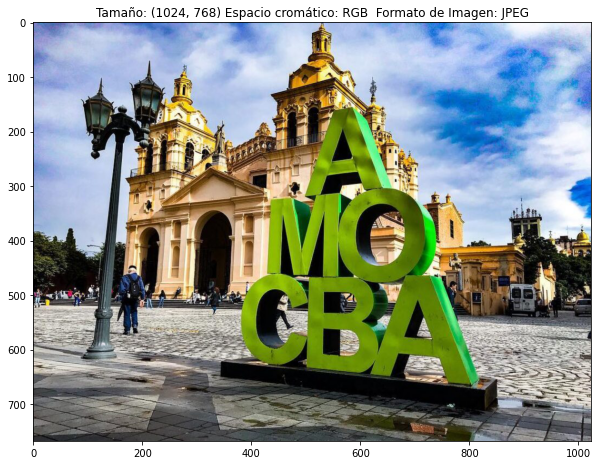

In [ ]:
img_url =  'https://www.guiasdeviaje.travel/wp-content/uploads/2020/03/Catedral-Plaza-San-Mart%C3%ADn-jeziel_guijarro-1024x768.jpg'
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))
img_rgb = np.asarray(img)

plt.figure(figsize=(10,10))
plt.title('Tamaño: %s Espacio cromático: %s  Formato de Imagen: %s' % (str(img.size), str(img.mode), str(img.format)))
plt.imshow(img)
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Alfa: 1.5 - Beta: 1')

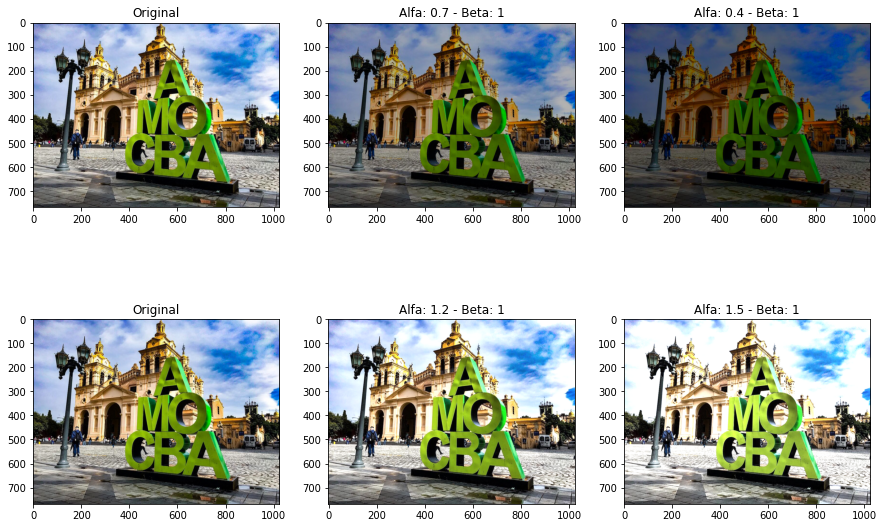

In [ ]:
alfa = [1, 0.7, 0.4, 1.2, 1.5]
beta = [1, 1, 1, 1, 1]
yiq_img = convert_RGB_to_YIQ(img_rgb)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

axs[0,0].imshow(get_custom_rgb_from_yiq(yiq_img, alfa[0], beta[0]))
axs[0,0].set_title('Original')

axs[0,1].imshow(get_custom_rgb_from_yiq(yiq_img, alfa[1], beta[1]))
axs[0,1].set_title(f'Alfa: {alfa[1]} - Beta: {beta[1]}')

axs[0,2].imshow(get_custom_rgb_from_yiq(yiq_img, alfa[2], beta[2]))
axs[0,2].set_title(f'Alfa: {alfa[2]} - Beta: {beta[2]}')

axs[1,0].imshow(get_custom_rgb_from_yiq(yiq_img, alfa[0], beta[0]))
axs[1,0].set_title(f'Original')

axs[1,1].imshow(get_custom_rgb_from_yiq(yiq_img, alfa[3], beta[3]))
axs[1,1].set_title(f'Alfa: {alfa[3]} - Beta: {beta[3]}')

axs[1,2].imshow(get_custom_rgb_from_yiq(yiq_img, alfa[4], beta[4]))
axs[1,2].set_title(f'Alfa: {alfa[4]} - Beta: {beta[4]}')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Alfa: 1 - Beta: 1.5')

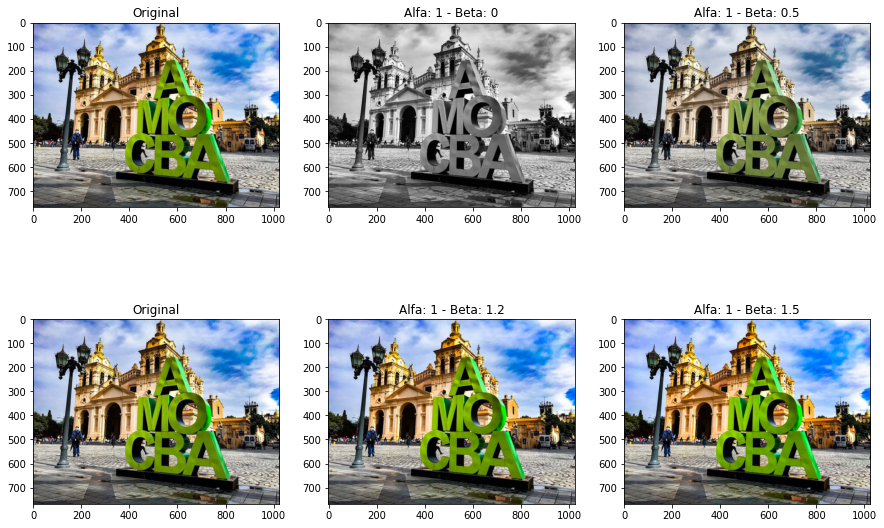

In [ ]:
alfa = [1, 1, 1, 1, 1]
beta = [1, 0, 0.5, 1.2, 1.5]

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

axs[0,0].imshow(get_custom_rgb_from_yiq(yiq_img, alfa[0], beta[0]))
axs[0,0].set_title('Original')

axs[0,1].imshow(get_custom_rgb_from_yiq(yiq_img, alfa[1], beta[1]))
axs[0,1].set_title(f'Alfa: {alfa[1]} - Beta: {beta[1]}')

axs[0,2].imshow(get_custom_rgb_from_yiq(yiq_img, alfa[2], beta[2]))
axs[0,2].set_title(f'Alfa: {alfa[2]} - Beta: {beta[2]}')


axs[1,0].imshow(get_custom_rgb_from_yiq(yiq_img, alfa[0], beta[0]))
axs[1,0].set_title(f'Original')

axs[1,1].imshow(get_custom_rgb_from_yiq(yiq_img, alfa[3], beta[3]))
axs[1,1].set_title(f'Alfa: {alfa[3]} - Beta: {beta[3]}')

axs[1,2].imshow(get_custom_rgb_from_yiq(yiq_img, alfa[4], beta[4]))
axs[1,2].set_title(f'Alfa: {alfa[4]} - Beta: {beta[4]}')

In [ ]:
yiq_img = convert_RGB_to_YIQ(img_rgb)

alfa, beta, filtros = get_widgets()

def square1(alfa, beta):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    axs[0].imshow(get_custom_rgb_from_yiq(yiq_img))
    axs[0].set_title('Original')
    axs[1].imshow(get_custom_rgb_from_yiq(yiq_img, alfa=alfa, beta=beta))
    axs[1].set_title(f'Alfa: {alfa} - Beta: {beta}')
    #plt.imshow(get_custom_rgb_from_yiq(yiq_img, number))

out = wg.interactive_output(square1, {'alfa': alfa, 'beta': beta});
wg.HBox([wg.VBox([alfa, beta, out])])


# Ejercicio 1.2
* Desarrollar un aplicativo que pueda abrir una imagen, manipule su histograma de luminancias, y luego ver la imagen procesada.
* Se debe poder elegir filtro raíz, cuadrado, o lineal a trozos.Los controles para elegir los filtros los organizan como les resulte más cómodo.

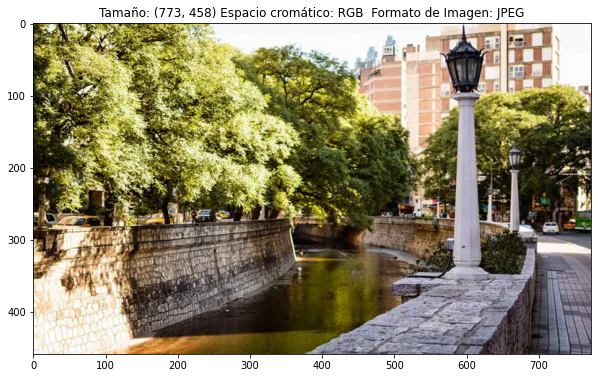

In [ ]:
img_url =  'https://d35hsl9am8s2ta.cloudfront.net/public/images/2019/11/La-ca%C3%B1ada-773x458.jpeg'
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))
img_rgb = np.asarray(img)

plt.figure(figsize=(10,10))
plt.title('Tamaño: %s Espacio cromático: %s  Formato de Imagen: %s' % (str(img.size), str(img.mode), str(img.format)))
plt.imshow(img)
plt.show()

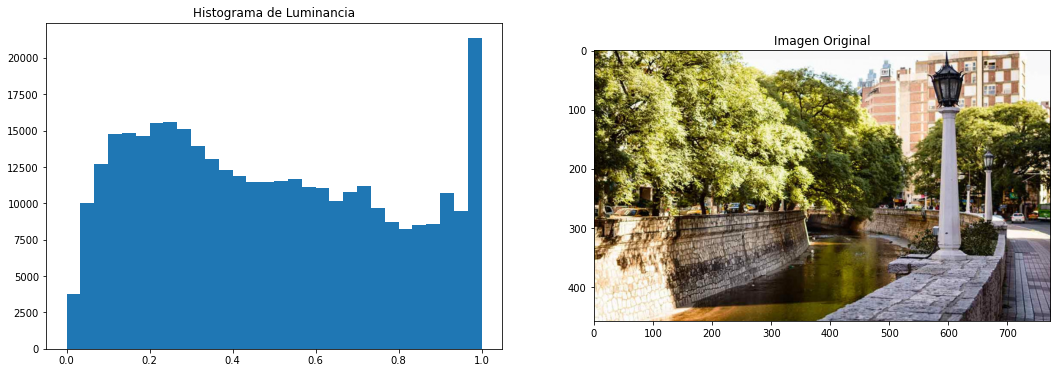

In [ ]:
img_yiq = convert_RGB_to_YIQ(img_rgb)

plot_histograma_imagen(img_yiq, 30, 'Imagen Original')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


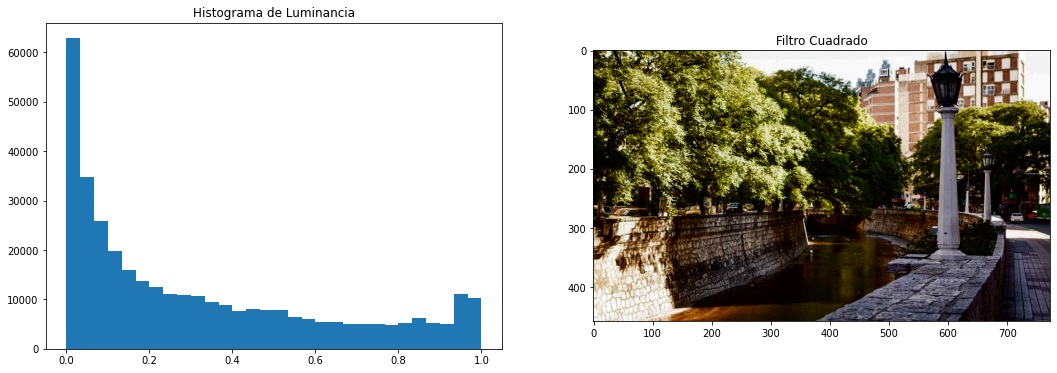

In [ ]:
#Filtro cuadradro.
img_filtered = filtro_cuadrado(img_yiq)
plot_histograma_imagen(img_filtered, 30, 'Filtro Cuadrado')



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


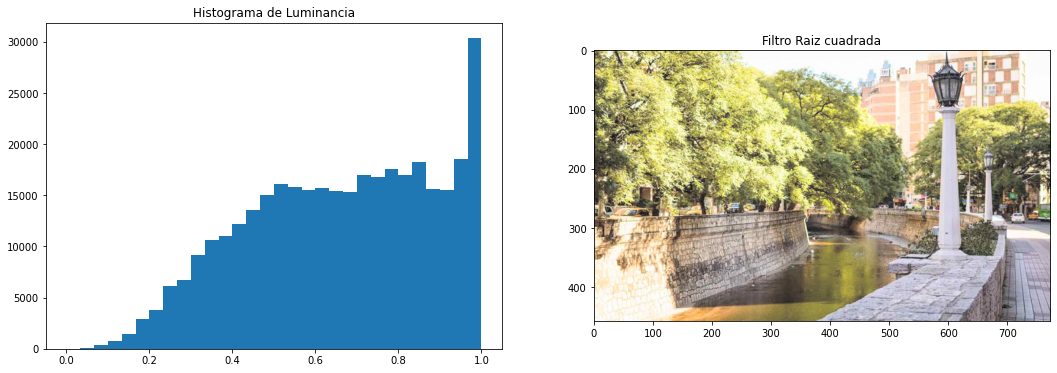

In [ ]:
#Filtro raiz cuadrada.
img_filtered = filtro_raiz_cuadrada(img_yiq)
plot_histograma_imagen(img_filtered, 30, 'Filtro Raiz cuadrada')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


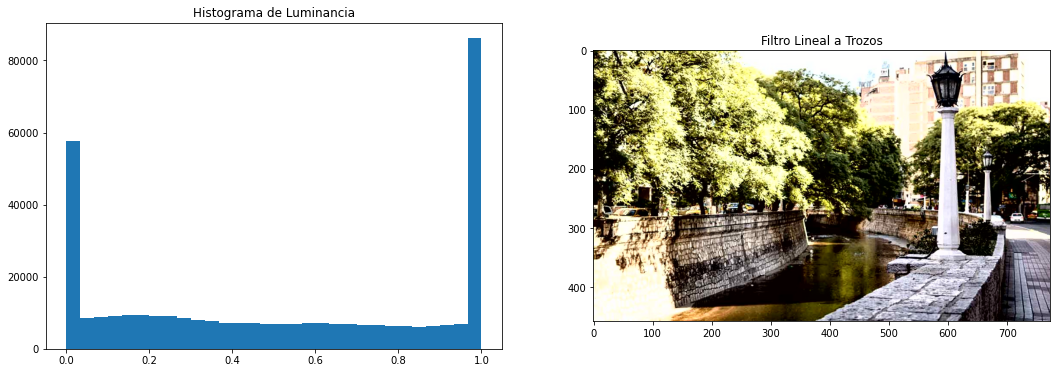

In [ ]:
img_filtered = filtro_lineal_a_trozos(img_yiq, 0.15, 0.75)
plot_histograma_imagen(img_filtered, 30, 'Filtro Lineal a Trozos')